In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

lugares_electricaribe = ["Barranquilla", "Cartagena	"]

files = os.listdir("csv/registro_continuo/")
df_complete = pd.DataFrame()
for file in files:
    df_file = pd.read_csv("csv/registro_continuo/" + file)
    if len(df_complete) > 0:
        df_complete = df_complete.append(df_file, ignore_index=True)
    else:
        df_complete = df_file
    
df_complete["fecha_creacion"] = pd.to_datetime(df_complete["fecha_creacion"]) - pd.Timedelta("5 hours")
df_complete["conteo_retweets"] = df_complete["conteo_retweets"].values.astype(int)
df_complete = df_complete[~df_complete["ciudades"].isin(
    ["Colombia", "Colombia, Cartagena", "Colombia, Nariño", "Colombia, Bogota"]
)]

df_complete = df_complete[~df_complete["empresas"].isin(
    ["Electricaribe, Codensa", "Electricaribe, EPM"]
)]

df_complete = df_complete[~df_complete["palabras_clave"].isin(
    ["Petro"]
)]

df_complete = df_complete.drop(columns=['number','palabras_clave'])

df_complete = df_complete[~pd.isna(df_complete["texto"])]

#df_complete = df_complete[df_complete["texto"].str.contains(" en ", regex = True)]

df_complete = df_complete.loc[:, ~df_complete.columns.str.contains('^Unnamed')]
df_complete["texto"] = df_complete["texto"].replace("\\n", ' ', regex = True)
#df_complete["texto"] = df_complete["texto"].replace('http[s]?[^$|\s]*', '', regex = True)
df_complete = df_complete.sort_values(by=["conteo_retweets"])

df_emcali = df_complete[df_complete["texto"].str.contains("[@]?[eE][mM][cC][aA][lL][iI]")]
df_complete = df_complete[~df_complete["ciudades"].isin(["Cali"])]
df_complete = df_complete.append(df_emcali)

df_complete.loc[(df_complete["ciudades"] == "Barranquilla") & pd.isna(df_complete["empresas"]), "empresas"] = "Electricaribe"
df_complete.loc[(df_complete["ciudades"] == "Cartagena") & pd.isna(df_complete["empresas"]), "empresas"] = "Electricaribe"
df_complete.loc[(df_complete["ciudades"] == "Bogotá") & pd.isna(df_complete["empresas"]), "empresas"] = "Codensa"
df_complete.loc[(df_complete["ciudades"] == "Bogota") & pd.isna(df_complete["empresas"]), "empresas"] = "Codensa"
df_complete.loc[(df_complete["ciudades"] == "Cali") & pd.isna(df_complete["empresas"]), "empresas"] = "EMCALI"
df_complete.loc[(df_complete["ciudades"] == "Nariño") & pd.isna(df_complete["empresas"]), "empresas"] = "Cedenar"
df_complete.loc[(df_complete["ciudades"] == "Villavicencio") & pd.isna(df_complete["empresas"]), "empresas"] = "Emsa"

df_complete = df_complete.drop_duplicates(["texto"], keep="last")
df_complete = df_complete.drop_duplicates(["autor","fecha_creacion"], keep="first")

,autor,ciudades,conteo_retweets,empresas,fecha_creacion,texto
3218,gothsarv,NaN,0,Codensa,2018-08-07 17:51:41,"@CodensaEnergia Hola, en el barrio Galicia d..."


In [3]:
df_complete["horas"] = df_complete["texto"].str.extract(
    r'(?P<horas>\d+(?=.{0}[ ]{0,5}?[hH][oO][rR][aA][sS]?))', 
    expand = True
)
df_complete["horas"] = df_complete["horas"].fillna(0)
df_complete["horas"] = df_complete["horas"].astype(int)
df_complete["dias"] = df_complete["texto"].str.extract(
    r'(?P<dias>\d+(?=.{0}[ ]{0,5}?[dD][iíIÍ][aA][sS]?))', 
    expand = True
)
df_complete["dias"] = df_complete["dias"].fillna(0)
df_complete["dias"] = df_complete["dias"].astype(int)

df_complete.loc[df_complete["conteo_retweets"].astype(int) == 0, "riesgo"] = "1"
df_complete.loc[df_complete["horas"].astype(int) == 0, "riesgo"] = "1"

df_complete.loc[df_complete["conteo_retweets"].astype(int) > 0, "riesgo"] = "2"
df_complete.loc[df_complete["horas"].astype(int) > 0, "riesgo"] = "2"

df_complete.loc[df_complete["conteo_retweets"].astype(int) >= 20, "riesgo"] = "3"
df_complete.loc[df_complete["horas"].astype(int) >= 12, "riesgo"] = "3"
df_complete.loc[df_complete["dias"].astype(int) > 0, "riesgo"] = "3"

print("completo", len(df_complete))
print("Bajo", len(df_complete[df_complete["riesgo"] == "1"]))
print("Medio", len(df_complete[df_complete["riesgo"] == "2"]))
print("Alto", len(df_complete[df_complete["riesgo"] == "3"]))

completo 1767
Bajo 1199
Medio 410
Alto 158


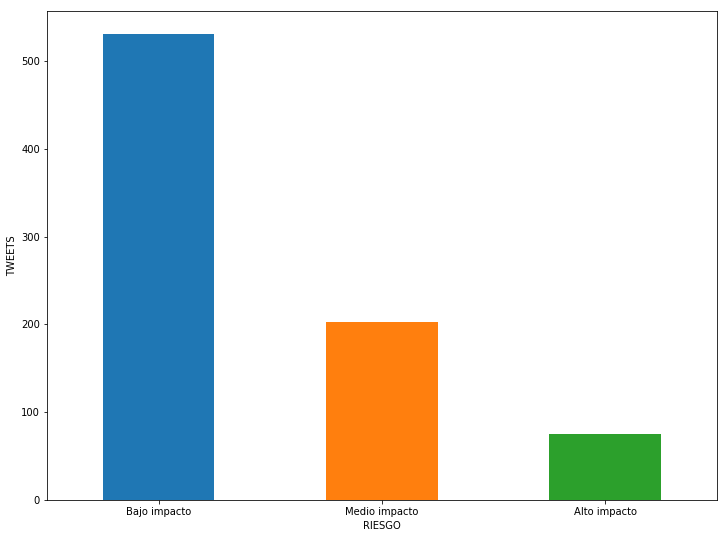

In [33]:
df_graph = df_complete[["riesgo", "dias", "horas", "fecha_creacion"]]
df_graph.columns = ["Riesgo", "dias", "horas", "fecha_creacion"]
df_graph = df_graph.sort_values(by=["Riesgo"])

df_graph.loc[df_graph["Riesgo"] == "1", "Riesgo"] = "Bajo impacto"
df_graph.loc[df_graph["Riesgo"] == "2", "Riesgo"] = "Medio impacto"
df_graph.loc[df_graph["Riesgo"] == "3", "Riesgo"] = "Alto impacto"

riesgo_group = df_graph.groupby("Riesgo").agg({
    "Riesgo":["count"]
})

riesgo_group.columns = ["Conteo"]
riesgo_group = riesgo_group.sort_values(by=["Conteo"], ascending=False)
riesgo_group["Porcentaje"] = 100 * riesgo_group["Conteo"] / np.sum(riesgo_group["Conteo"])

riesgo_graph = riesgo_group["Conteo"].plot(kind="bar", rot=0)
riesgo_graph.set_xlabel("RIESGO")
riesgo_graph.set_ylabel("TWEETS")
riesgo_graph

In [34]:
df_graph = df_complete[["riesgo", "dias", "horas", "fecha_creacion", "empresas"]]
df_graph.columns = ["Riesgo", "dias", "horas", "fecha_creacion", "Empresas"]
df_graph.loc[df_graph["Riesgo"] == "1", "Riesgo"] = "Bajo impacto"
df_graph.loc[df_graph["Riesgo"] == "2", "Riesgo"] = "Medio impacto"
df_graph.loc[df_graph["Riesgo"] == "3", "Riesgo"] = "Alto impacto"

riesgo_empresas_grouped = df_graph.groupby(["Empresas", "Riesgo"]).agg({
    "Riesgo":"count"
})

riesgo_empresas_grouped.columns = ["Conteo"]
riesgo_empresas_grouped

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Conteo
Empresas      Riesgo               
Cedenar       Bajo impacto        2
Codensa       Alto impacto       40
              Bajo impacto      178
              Medio impacto      54
EMCALI        Alto impacto        1
              Bajo impacto       23
              Medio impacto       7
EPM           Alto impacto        1
              Bajo impacto        9
              Medio impacto       3
Ebsa          Bajo impacto        1
              Medio impacto       2
Electricaribe Alto impacto       27
              Bajo impacto      226
              Medio impacto     101
Emsa          Alto impacto        1
              Bajo impacto       34
              Medio impacto       8
Enertolima    Bajo impacto        3
Epsa          Alto impacto        1

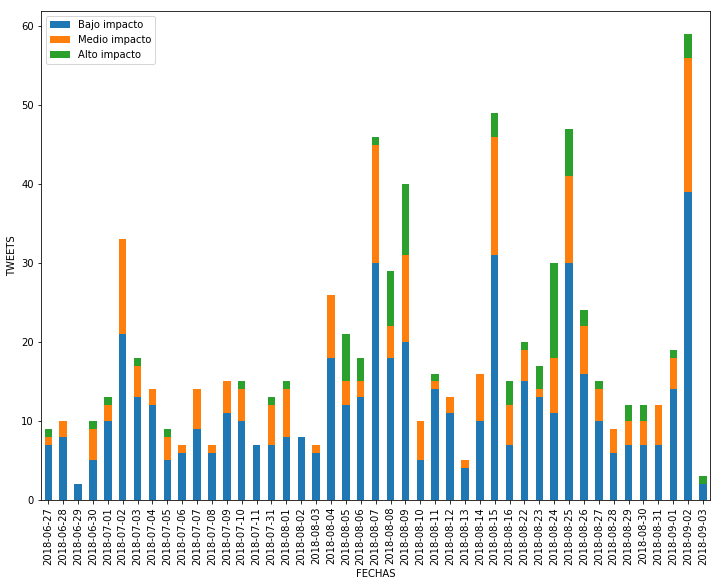

In [35]:
df_graph = df_complete[["riesgo", "dias", "horas", "fecha_creacion"]]
df_graph = df_graph.sort_values(by=["fecha_creacion"])
df_graph.columns = ["Riesgo", "dias", "horas", "Fecha"]
df_graph["Fecha"] = df_graph["Fecha"].dt.strftime("%Y-%m-%d")

fechas_group = df_graph.groupby(["Fecha", "Riesgo"]).agg({
    "Riesgo":["count"]
})

fechas_group = fechas_group.unstack()
fechas_group.columns = ["Bajo impacto", "Medio impacto", "Alto impacto"]

fechas_graph = fechas_group.plot(kind = 'bar', stacked = True)
fechas_graph.set_xlabel("FECHAS")
fechas_graph.set_ylabel("TWEETS")
fechas_graph

In [36]:
df_graph = df_complete[["riesgo", "dias", "horas", "fecha_creacion", "empresas"]]
df_graph.columns = ["Riesgo", "dias", "horas", "fecha_creacion", "Empresas"]
df_graph = df_graph.sort_values(by=["fecha_creacion"])
df_graph["fecha_creacion"] = df_graph["fecha_creacion"].dt.strftime("%Y-%m-%d")

empresas_group = df_graph.groupby(["Empresas", "Riesgo"]).agg({
    "Riesgo":["count"]
})

empresas_group = empresas_group.unstack()
empresas_group.columns = ["Bajo impacto", "Medio impacto", "Alto impacto"]

empresas_group["Alto impacto"] = empresas_group["Alto impacto"].fillna(0)
empresas_group["Bajo impacto"] = empresas_group["Bajo impacto"].fillna(0)
empresas_group["Medio impacto"] = empresas_group["Medio impacto"].fillna(0)

empresas_group["Alto impacto"] = empresas_group["Alto impacto"].astype(int)
empresas_group["Bajo impacto"] = empresas_group["Bajo impacto"].astype(int)
empresas_group["Medio impacto"] = empresas_group["Medio impacto"].astype(int)

empresas_group

,Bajo impacto,Medio impacto,Alto impacto
Empresas,,,
Cedenar,2,0,0
Codensa,178,54,40
EMCALI,23,7,1
EPM,9,3,1
Ebsa,1,2,0
Electricaribe,226,101,27
Emsa,34,8,1
Enertolima,3,0,0
Epsa,0,0,1


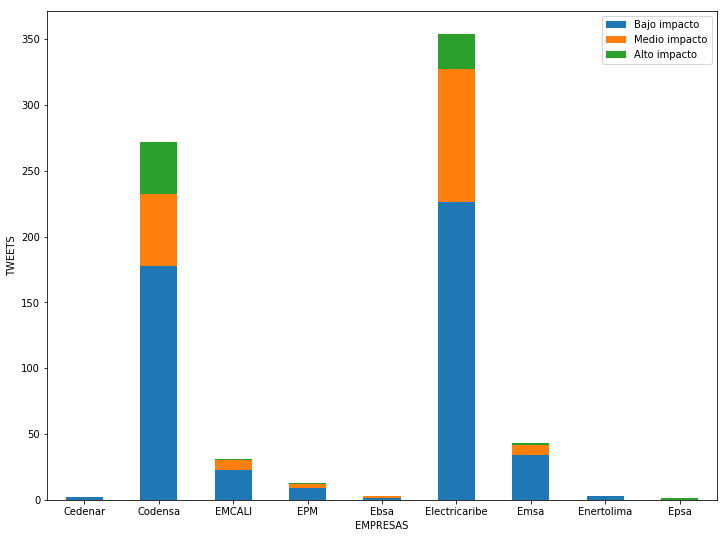

In [37]:
empresas_graph = empresas_group.plot(kind = 'bar', stacked = True, rot=0)
empresas_graph.set_xlabel("EMPRESAS")
empresas_graph.set_ylabel("TWEETS")
empresas_graph

In [42]:
df_empresa = df_complete[
    df_complete["empresas"] == "Electricaribe"
].sort_values(by=["conteo_retweets"], ascending=False)

df_empresa.to_csv("tweets_electricaribe.csv", sep = "|", index = False)

#df_complete.to_csv("tweets_riesgo_.csv", sep = "|", index = False)